<a href="https://colab.research.google.com/github/HeytorAlves/CartorioEbac/blob/main/C%C3%B3pia_de_sistema_reconhecimento_facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv4 Object Detection on Webcam In Google Colab
This notebook will walkthrough all the steps for performing YOLOv4 object detections on your webcam while in Google Colab. We will be using scaled-YOLOv4 (yolov4-csp) for this tutorial, the fastest and most accurate object detector there currently is.

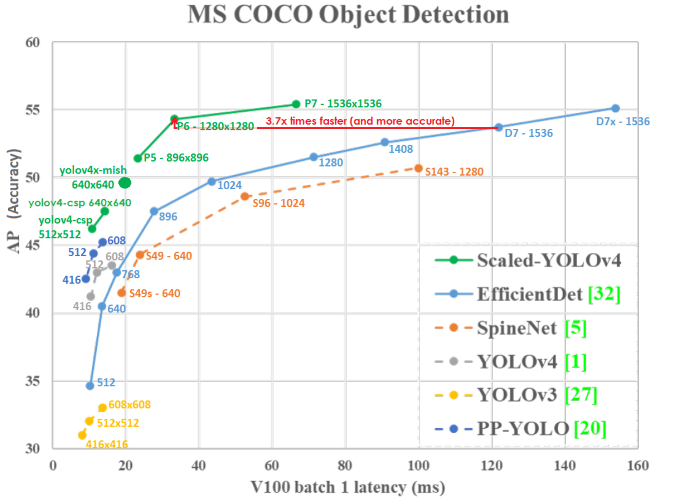

In [4]:

# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [5]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [6]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [7]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [8]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

NotAllowedError: Permission denied


In [9]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [11]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

/tmp/ipython-input-480462610.py:27: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')


Diretórios configurados com sucesso!
Classe H: /content/h
Classe B: /content/b
Faces extraídas: /content/faces_dataset

=== VERIFICANDO IMAGENS DA CLASSE H ===
Encontradas 12 imagens em /content/h
  - h (19).jpg
  - h (17).JPG
  - h (18).JPG
  - h (22).jpg
  - h (21).jpg
  - h (16).jpg
  - h (14).jpg
  - h (15).jpg
  - h (6).jpg
  - h (1).jpg
  - h (23).jpg
  - h (20).jpg

=== VERIFICANDO IMAGENS DA CLASSE B ===
Encontradas 12 imagens em /content/b
  - b (4).jpg
  - b (3).jpg
  - b (2).jpg
  - b (1).jpg
  - b (8).jpg
  - b (5).jpg
  - b (7).jpg
  - b (11).jpg
  - b (9).jpg
  - b (6).jpg
  - b (10).jpg
  - b (12).jpg

INICIANDO EXTRAÇÃO DE ROSTOS

=== EXTRAINDO ROSTOS DA CLASSE H ===
✓ Rosto 1 extraído de h (19).jpg -> H_h (19)_0.jpg
✓ Rosto 1 extraído de h (17).JPG -> H_h (17)_0.jpg
✓ Rosto 2 extraído de h (17).JPG -> H_h (17)_1.jpg
✓ Rosto 1 extraído de h (18).JPG -> H_h (18)_0.jpg
✓ Rosto 2 extraído de h (18).JPG -> H_h (18)_1.jpg
✓ Rosto 3 extraído de h (18).JPG -> H_h (18)_2.jpg
✓ 

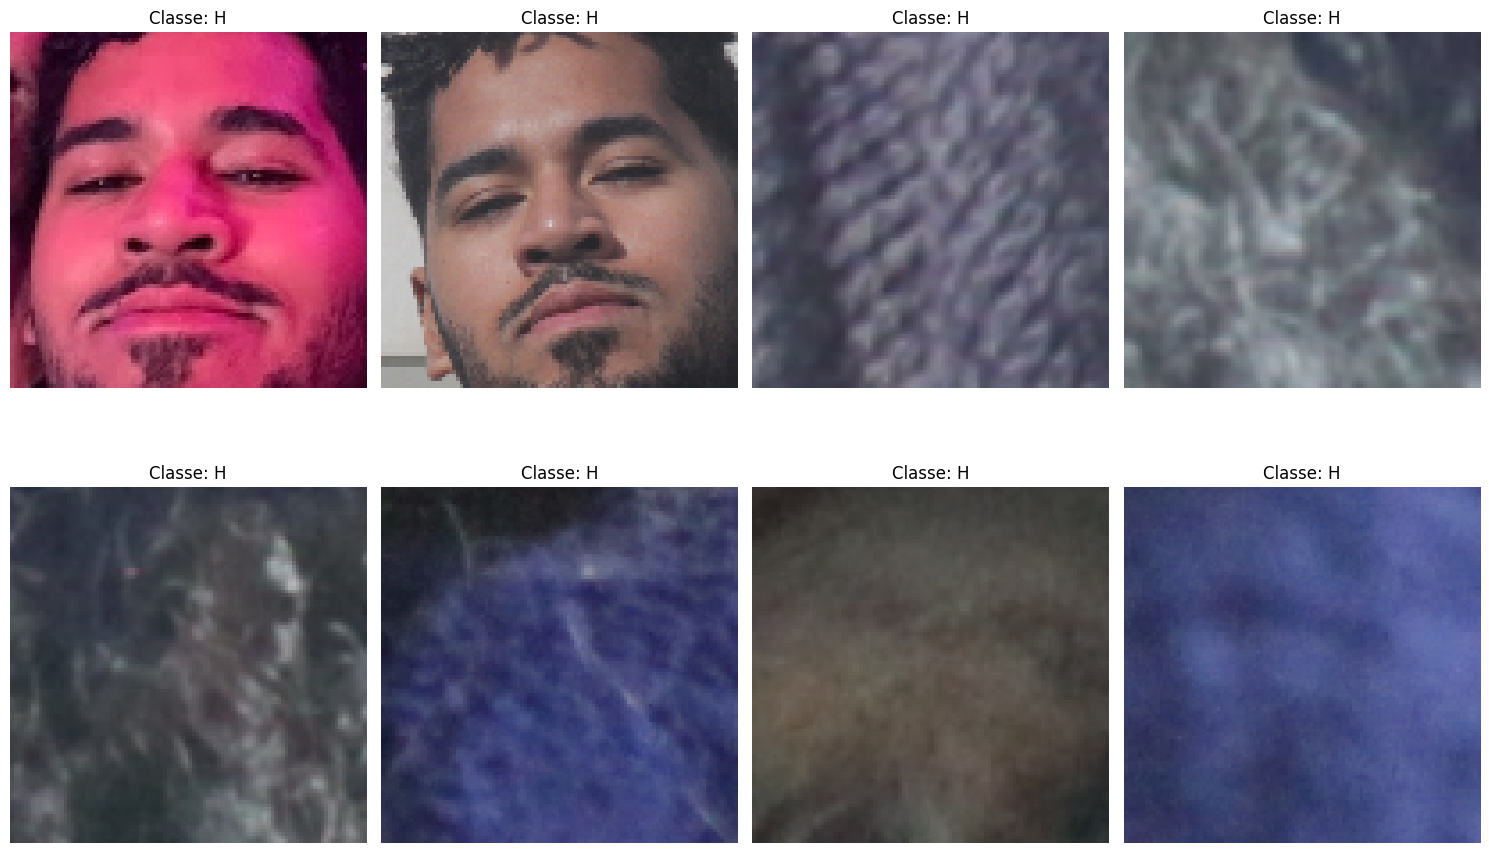


 BANCO DE DADOS CRIADO COM SUCESSO!

 Próximos passos:
1. O dataset está salvo em '/content/faces_dataset.pkl'
2. As faces extraídas estão em '/content/faces_dataset/'
3. Use este dataset para treinar seu classificador posteriormente

 Arquivos no dataset (/content/faces_dataset):
  - B_b (1)_0.jpg
  - H_h (1)_2.jpg
  - H_h (16)_0.jpg
  - B_b (2)_0.jpg
  - H_h (18)_3.jpg
  - B_b (8)_2.jpg
  - H_h (19)_0.jpg
  - H_h (18)_0.jpg
  - H_h (17)_1.jpg
  - H_h (6)_1.jpg
  ... e mais 23 arquivos


In [12]:
# CÓDIGO COMPLEMENTAR - CRIAÇÃO DO BANCO DE DADOS
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle

# Definir caminhos das pastas (conforme seu ambiente)
H_PATH = "/content/h"  # Classe H
B_PATH = "/content/b"  # Classe B
DATASET_PATH = "/content/faces_dataset"  # Onde salvar as faces extraídas

# Criar diretório para as faces extraídas
!mkdir -p {DATASET_PATH}

print("Diretórios configurados com sucesso!")
print(f"Classe H: {H_PATH}")
print(f"Classe B: {B_PATH}")
print(f"Faces extraídas: {DATASET_PATH}")

# Verificar se as pastas existem
if not os.path.exists(H_PATH):
    print(f"ATENÇÃO: Pasta {H_PATH} não encontrada!")
    print("Por favor, faça upload das imagens da classe H para esta pasta")

if not os.path.exists(B_PATH):
    print(f"ATENÇÃO: Pasta {B_PATH} não encontrada!")
    print("Por favor, faça upload das imagens da classe B para esta pasta")

# Função para verificar e listar imagens nas pastas
def check_images_in_folder(folder_path, class_name):
    """Verifica e lista as imagens em uma pasta"""
    print(f"\n=== VERIFICANDO IMAGENS DA CLASSE {class_name} ===")

    if not os.path.exists(folder_path):
        print(f"Pasta {folder_path} não existe!")
        return []

    # Listar arquivos de imagem
    image_files = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_files.append(filename)

    print(f"Encontradas {len(image_files)} imagens em {folder_path}")
    for img in image_files:
        print(f"  - {img}")

    return image_files

# Verificar imagens disponíveis
h_images = check_images_in_folder(H_PATH, "H")
b_images = check_images_in_folder(B_PATH, "B")

# Função para detectar e extrair rostos das imagens
def extract_faces_from_folder(folder_path, class_label):
    """
    Extrai rostos das imagens de uma pasta específica
    """
    print(f"\n=== EXTRAINDO ROSTOS DA CLASSE {class_label} ===")

    faces_data = []
    labels = []
    extracted_count = 0

    if not os.path.exists(folder_path):
        print(f"Pasta {folder_path} não existe! Pulando...")
        return faces_data, labels

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Não foi possível ler a imagem: {filename}")
                continue

            # Converter para escala de cinza
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Detectar faces usando o mesmo Haar Cascade do seu código
            faces = face_cascade.detectMultiScale(
                gray,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(30, 30)
            )

            if len(faces) == 0:
                print(f"Nenhum rosto detectado em: {filename}")
                continue

            for i, (x, y, w, h) in enumerate(faces):
                # Extrair ROI (Region of Interest)
                face_roi = image[y:y+h, x:x+w]

                # Redimensionar para tamanho padrão
                face_resized = cv2.resize(face_roi, (100, 100))

                # Salvar face extraída
                face_filename = f"{class_label}_{filename.split('.')[0]}_{i}.jpg"
                face_path = os.path.join(DATASET_PATH, face_filename)
                cv2.imwrite(face_path, face_resized)

                # Adicionar aos dados de treinamento
                faces_data.append(face_resized)
                labels.append(class_label)

                extracted_count += 1
                print(f"✓ Rosto {i+1} extraído de {filename} -> {face_filename}")

    print(f"Total de rostos extraídos da classe {class_label}: {extracted_count}")
    return faces_data, labels

# Extrair rostos de ambas as classes
print("\n" + "="*50)
print("INICIANDO EXTRAÇÃO DE ROSTOS")
print("="*50)

all_faces_data = []
all_labels = []

# Extrair da classe H
h_faces, h_labels = extract_faces_from_folder(H_PATH, "H")
all_faces_data.extend(h_faces)
all_labels.extend(h_labels)

# Extrair da classe B
b_faces, b_labels = extract_faces_from_folder(B_PATH, "B")
all_faces_data.extend(b_faces)
all_labels.extend(b_labels)

print(f"\n=== RESUMO FINAL DO DATASET ===")
print(f"Total de rostos extraídos: {len(all_faces_data)}")
print(f"Rostos da classe H: {all_labels.count('H')}")
print(f"Rostos da classe B: {all_labels.count('B')}")

# Salvar o dataset em arquivo pickle para uso futuro
if all_faces_data:
    dataset = {
        'faces': all_faces_data,
        'labels': all_labels
    }

    with open('/content/faces_dataset.pkl', 'wb') as f:
        pickle.dump(dataset, f)

    print("\n Dataset salvo em '/content/faces_dataset.pkl'")

    # Função para visualizar algumas amostras do dataset
    def show_dataset_samples():
        """Mostra algumas amostras do dataset criado"""
        print("\n=== AMOSTRAS DO DATASET ===")

        plt.figure(figsize=(15, 10))

        # Mostrar até 8 amostras
        num_samples = min(8, len(all_faces_data))

        for i in range(num_samples):
            plt.subplot(2, 4, i+1)

            # Converter BGR para RGB para visualização correta
            img_rgb = cv2.cvtColor(all_faces_data[i], cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
            plt.title(f'Classe: {all_labels[i]}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Mostrar amostras
    show_dataset_samples()

    print("\n BANCO DE DADOS CRIADO COM SUCESSO!")
    print("\n Próximos passos:")
    print("1. O dataset está salvo em '/content/faces_dataset.pkl'")
    print("2. As faces extraídas estão em '/content/faces_dataset/'")
    print("3. Use este dataset para treinar seu classificador posteriormente")

else:
    print("Nenhum rosto foi extraído. Verifique se:")
    print("   - As pastas /content/h e /content/b existem")
    print("   - Há imagens válidas nas pastas")
    print("   - As imagens contêm rostos detectáveis")

# Listar arquivos no dataset criado
print(f"\n Arquivos no dataset ({DATASET_PATH}):")
if os.path.exists(DATASET_PATH):
    dataset_files = os.listdir(DATASET_PATH)
    for file in dataset_files[:10]:  # Mostrar primeiros 10 arquivos
        print(f"  - {file}")
    if len(dataset_files) > 10:
        print(f"  ... e mais {len(dataset_files) - 10} arquivos")
else:
    print("Pasta do dataset não encontrada")

In [13]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Cloning and Setting Up Darknet for YOLOv4
We will be using the famous AlexeyAB's darknet repository in this tutorial to perform YOLOv4 detections.

In [14]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


In [15]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [16]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1443:14: warning: unused variable ‘buff’ []8;;https:/

In [17]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2025-09-07 06:21:10--  https://docs.google.com/uc?export=download&confirm=&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 108.177.96.139, 108.177.96.101, 108.177.96.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.96.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq&export=download [following]
--2025-09-07 06:21:10--  https://drive.usercontent.google.com/download?id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.31.132, 2a00:1450:4013:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.31.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2430 (2.4K) [text/html]
Saving to: ‘yolov4-csp.weights’

yolov4-csp.weights  100%[===================>]   2.37K  --.-KB/s    in 0s 

## Darknet for Python
In order to utilize YOLOv4 with Python code we will use some of the pre-built functions found within darknet.py by importing the functions into our workstation. Feel free to checkout the darknet.py file to see the function definitions in detail!

In [18]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## YOLOv4 Example on Test Image
Let's make sure our model has successfully been loaded and that we can make detections properly on a test image.

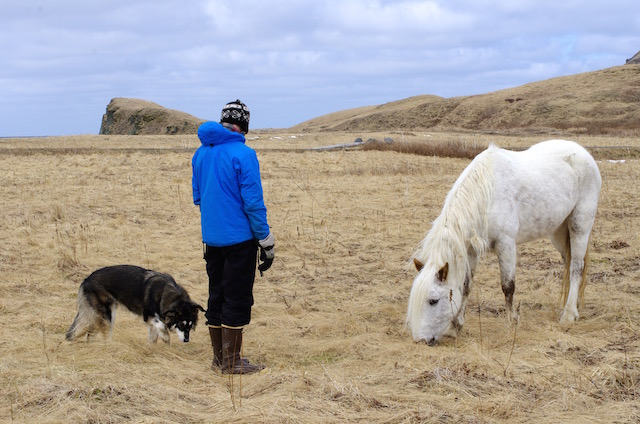

In [19]:
# run test on person.jpg image that comes with repository
image = cv2.imread("data/person.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

## Helper Functions
Here are a few helper functions defined that will be used to easily convert between different image types within our later steps.

In [20]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## YOLOv4 on Wecam Images
Running YOLOv4 on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** which runs JavaScript code to utilize your computer's webcam. The code snippet will take a webcam photo, which we will then pass into our YOLOv4 model for object detection.

Below is a function to take the webcam picture using JavaScript and then run YOLOv4 on it.

In [21]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)

  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


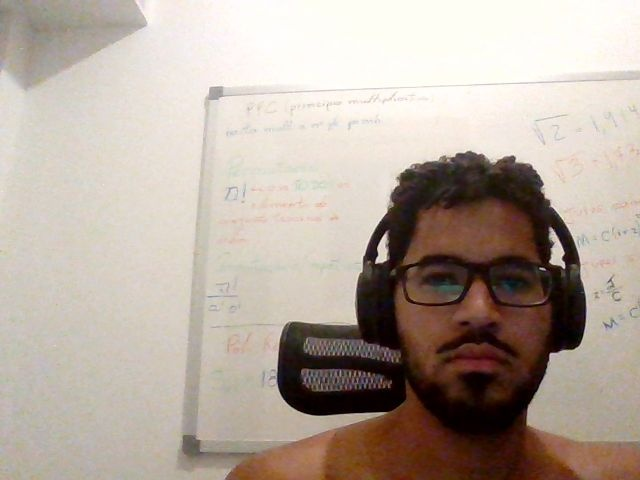

In [22]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## YOLOv4 on Webcam Videos
Running YOLOv4 on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our YOLOv4 model and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

YOLOv4 is so fast that it can run the detections in real-time!

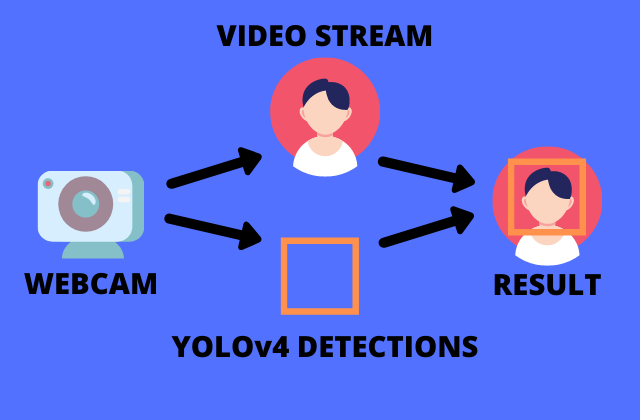

Below is a function to start up the video stream using similar JavaScript as was used for images. The video stream frames are fed as input to YOLOv4.

In [23]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

In [24]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

/tmp/ipython-input-480462610.py:27: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')


=== INICIANDO TREINAMENTO DO CLASSIFICADOR H/B ===

1. CARREGANDO IMAGENS...
Processando classe H...
OK h (19).jpg processado
OK h (17).JPG processado
OK h (18).JPG processado
OK h (22).jpg processado
OK h (21).jpg processado
OK h (16).jpg processado
OK h (14).jpg processado
OK h (15).jpg processado
OK h (6).jpg processado
OK h (1).jpg processado
OK h (23).jpg processado
OK h (20).jpg processado
Processando classe B...
OK b (4).jpg processado
OK b (3).jpg processado
OK b (2).jpg processado
OK b (1).jpg processado
OK b (8).jpg processado
OK b (5).jpg processado
OK b (7).jpg processado
OK b (11).jpg processado
OK b (9).jpg processado
OK b (6).jpg processado
OK b (10).jpg processado
OK b (12).jpg processado

2. DATASET CARREGADO:
   - Total de amostras: 24
   - Classe H: 12 imagens
   - Classe B: 12 imagens

3. PREPROCESSANDO LABELS...
   - Labels originais: ['B' 'H']
   - Mapping: {np.str_('B'): np.int64(0), np.str_('H'): np.int64(1)}

4. DIVIDINDO EM TREINO E TESTE...
   - Treino: 19 am

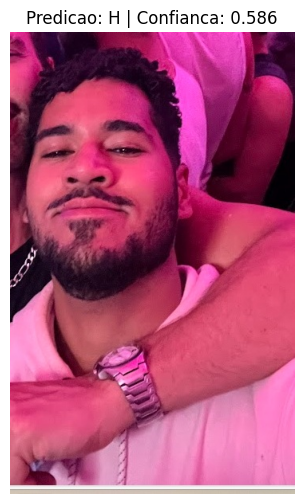

Imagem: h (19).jpg
Classe predita: H
Confianca: 0.586

Testando imagem B: b (4).jpg


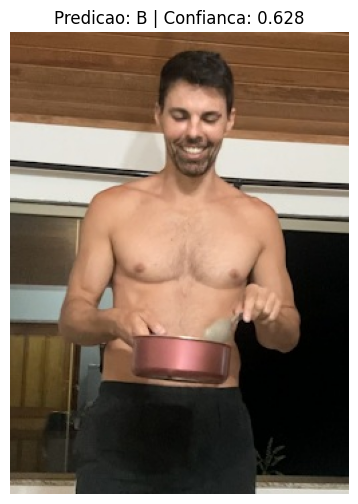

Imagem: b (4).jpg
Classe predita: B
Confianca: 0.628

TREINAMENTO CONCLUIDO COM SUCESSO!

INFORMACOES DO MODELO:
   - Tipo: SVM com kernel linear
   - Numero de features: 30000
   - Numero de classes: 2
   - Classes: ['B' 'H']

Pronto para integrar com o sistema de detecao!


In [30]:
# TREINAMENTO DO CLASSIFICADOR H/B (VERSÃO CORRIGIDA)
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Configurações
H_PATH = "/content/h"  # Pasta com imagens da classe H
B_PATH = "/content/b"  # Pasta com imagens da classe B
MODEL_PATH = "/content/classifier_hb.pkl"  # Onde salvar o modelo
ENCODER_PATH = "/content/label_encoder.pkl"  # Onde salvar o encoder

print("=== INICIANDO TREINAMENTO DO CLASSIFICADOR H/B ===")

# Função para carregar e processar imagens
def load_and_process_images(folder_path, label):
    """
    Carrega imagens de uma pasta e extrai features
    """
    images = []
    labels = []

    if not os.path.exists(folder_path):
        print(f"ATENCAO: Pasta {folder_path} não encontrada!")
        return images, labels

    print(f"Processando classe {label}...")

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)

            if image is not None:
                # Redimensionar para tamanho padrão
                image_resized = cv2.resize(image, (100, 100))

                # Achatar a imagem para feature vector (usando colorido)
                flattened = image_resized.flatten()

                images.append(flattened)
                labels.append(label)

                print(f"OK {filename} processado")
            else:
                print(f"Erro ao ler {filename}")

    return images, labels

# Carregar imagens das duas classes
print("\n1. CARREGANDO IMAGENS...")
h_images, h_labels = load_and_process_images(H_PATH, "H")
b_images, b_labels = load_and_process_images(B_PATH, "B")

# Combinar dados
all_images = np.array(h_images + b_images)
all_labels = np.array(h_labels + b_labels)

print(f"\n2. DATASET CARREGADO:")
print(f"   - Total de amostras: {len(all_images)}")
print(f"   - Classe H: {len(h_images)} imagens")
print(f"   - Classe B: {len(b_images)} imagens")

if len(all_images) == 0:
    print("ERRO: Nenhuma imagem foi carregada. Verifique os caminhos das pastas.")
    exit()

# Codificar labels (H -> 0, B -> 1)
print("\n3. PREPROCESSANDO LABELS...")
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)

print(f"   - Labels originais: {label_encoder.classes_}")
print(f"   - Mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Dividir em treino e teste (80% treino, 20% teste)
print("\n4. DIVIDINDO EM TREINO E TESTE...")
X_train, X_test, y_train, y_test = train_test_split(
    all_images, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

print(f"   - Treino: {X_train.shape[0]} amostras")
print(f"   - Teste: {X_test.shape[0]} amostras")
print(f"   - Dimensionalidade: {X_train.shape[1]} features por amostra")

# Treinar classificador SVM
print("\n5. TREINANDO CLASSIFICADOR SVM...")
classifier = SVC(
    kernel='linear',
    C=1.0,
    probability=True,
    random_state=42
)

# Treinar o modelo
classifier.fit(X_train, y_train)
print("Treinamento concluido!")

# Avaliar o modelo
print("\n6. AVALIANDO O MODELO...")
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"   - Acuracia no teste: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   - Relatorio de classificacao:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Mostrar algumas predições de exemplo
print("\n7. EXEMPLOS DE PREDICAO:")
print("   Amostra | Real | Predito | Confianca")
print("   " + "-"*40)

for i in range(min(5, len(X_test))):
    sample = X_test[i].reshape(1, -1)
    real_label = label_encoder.inverse_transform([y_test[i]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[i]])[0]
    confidence = np.max(classifier.predict_proba(sample))

    print(f"   {i+1:6}  | {real_label:4} | {pred_label:6} | {confidence:.3f}")

# Salvar o modelo treinado
print("\n8. SALVANDO MODELO...")
joblib.dump(classifier, MODEL_PATH)
joblib.dump(label_encoder, ENCODER_PATH)

print(f"Modelo salvo em: {MODEL_PATH}")
print(f"LabelEncoder salvo em: {ENCODER_PATH}")

# Função para testar o modelo com uma imagem específica
def test_single_image(image_path, classifier, label_encoder):
    """
    Testa o classificador com uma imagem individual
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Nao foi possivel ler a imagem: {image_path}")
        return

    # Mesmo pré-processamento usado no treino
    image_resized = cv2.resize(image, (100, 100))
    flattened = image_resized.flatten().reshape(1, -1)

    # Fazer predição
    prediction = classifier.predict(flattened)
    confidence = np.max(classifier.predict_proba(flattened))
    class_name = label_encoder.inverse_transform(prediction)[0]

    # Mostrar resultado
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicao: {class_name} | Confianca: {confidence:.3f}')
    plt.axis('off')
    plt.show()

    print(f"Imagem: {os.path.basename(image_path)}")
    print(f"Classe predita: {class_name}")
    print(f"Confianca: {confidence:.3f}")

# Testar com uma imagem de exemplo de cada classe
print("\n9. TESTANDO COM IMAGENS EXEMPLO:")
if os.listdir(H_PATH):
    h_test_image = os.path.join(H_PATH, os.listdir(H_PATH)[0])
    print(f"\nTestando imagem H: {os.path.basename(h_test_image)}")
    test_single_image(h_test_image, classifier, label_encoder)

if os.listdir(B_PATH):
    b_test_image = os.path.join(B_PATH, os.listdir(B_PATH)[0])
    print(f"\nTestando imagem B: {os.path.basename(b_test_image)}")
    test_single_image(b_test_image, classifier, label_encoder)

print("\n" + "="*60)
print("TREINAMENTO CONCLUIDO COM SUCESSO!")
print("="*60)

# Mostrar informações do modelo (compatível)
print(f"\nINFORMACOES DO MODELO:")
print(f"   - Tipo: SVM com kernel {classifier.kernel}")
print(f"   - Numero de features: {X_train.shape[1]}")
print(f"   - Numero de classes: {len(np.unique(y_train))}")
print(f"   - Classes: {label_encoder.classes_}")

print("\nPronto para integrar com o sistema de detecao!")

=== INICIANDO SISTEMA DE DETECÇÃO E CLASSIFICAÇÃO H/B ===
 Classificador H/B carregado com sucesso!
Escolha uma opção:
1. Modo contínuo (webcam em tempo real)
2. Tirar foto única e classificar
Digite 1 ou 2: 2
Preparando para tirar foto...


<IPython.core.display.Javascript object>

 Nenhuma pessoa detectada na foto!


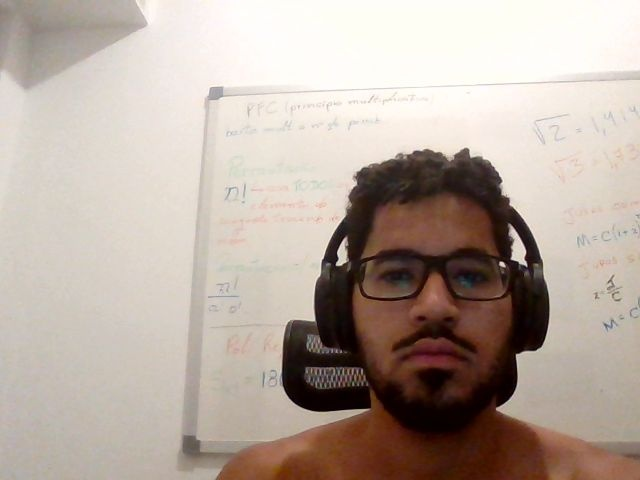

Sistema finalizado!


In [35]:
# SISTEMA COMPLETO DE DETECÇÃO E CLASSIFICAÇÃO FACIAL H/B
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import LabelEncoder
import time

# ==================== CONFIGURAÇÃO ====================
print("=== INICIANDO SISTEMA DE DETECÇÃO E CLASSIFICAÇÃO H/B ===")

# Carregar classificador treinado
try:
    classifier = joblib.load('/content/classifier_hb.pkl')
    label_encoder = joblib.load('/content/label_encoder.pkl')
    print(" Classificador H/B carregado com sucesso!")
except:
    print(" Classificador não encontrado. Execute o treinamento primeiro!")
    exit()

# ==================== FUNÇÕES AUXILIARES ====================
def extract_face_roi(frame, detection, width_ratio, height_ratio):
    """Extrai a região do rosto de uma detecção de pessoa"""
    label, confidence, bbox = detection
    if label != "person":
        return None

    left, top, right, bottom = bbox2points(bbox)
    left = int(left * width_ratio)
    top = int(top * height_ratio)
    right = int(right * width_ratio)
    bottom = int(bottom * height_ratio)

    # Ajustar para região facial
    height = bottom - top
    face_top = top + int(height * 0.15)
    face_bottom = top + int(height * 0.85)

    # Garantir limites da imagem
    face_top = max(0, face_top)
    face_bottom = min(frame.shape[0], face_bottom)
    left = max(0, left)
    right = min(frame.shape[1], right)

    if face_bottom > face_top and right > left:
        return frame[face_top:face_bottom, left:right]
    return None

def classify_face(face_roi):
    """Classifica um rosto como H ou B"""
    if face_roi is None or face_roi.size == 0:
        return "Unknown", 0.0

    try:
        face_resized = cv2.resize(face_roi, (100, 100))
        face_flattened = face_resized.flatten().reshape(1, -1)
        prediction = classifier.predict(face_flattened)
        confidence = np.max(classifier.predict_proba(face_flattened))
        class_name = label_encoder.inverse_transform(prediction)[0]
        return class_name, confidence
    except Exception as e:
        return "Error", 0.0

def show_classification_results(detections, frame, width_ratio, height_ratio):
    """Mostra resultados das classificações de forma organizada"""
    print("\n" + "="*50)
    print("RESULTADOS DA CLASSIFICACAO")
    print("="*50)

    h_count = 0
    b_count = 0
    unknown_count = 0
    results = []

    for i, detection in enumerate(detections):
        label, confidence, bbox_coords = detection

        if label == "person":
            face_roi = extract_face_roi(frame, detection, width_ratio, height_ratio)
            class_name, class_confidence = classify_face(face_roi)

            if class_name == "H":
                h_count += 1
            elif class_name == "B":
                b_count += 1
            else:
                unknown_count += 1

            # Guardar resultados para mostrar depois
            left, top, right, bottom = bbox2points(bbox_coords)
            left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)

            results.append({
                'pessoa': i+1,
                'classe': class_name,
                'confianca': class_confidence,
                'posicao': (left, top, right, bottom),
                'tamanho': (right-left, bottom-top)
            })

            print(f"Pessoa {i+1}: {class_name} (Confianca: {class_confidence:.3f})")
            print(f"  Posicao: ({left}, {top}) a ({right}, {bottom})")
            print(f"  Tamanho: {right-left}x{bottom-top} pixels")
            print("-" * 30)

    # Resumo geral
    print(f"\nRESUMO:")
    print(f"Total de pessoas detectadas: {len([d for d in detections if d[0] == 'person'])}")
    print(f"Classe H: {h_count} pessoa(s)")
    print(f"Classe B: {b_count} pessoa(s)")
    print(f"Nao classificadas: {unknown_count} pessoa(s)")

    return results, h_count, b_count

def take_photo_with_classification():
    """Tira uma foto e mostra os resultados de classificação"""
    print("Preparando para tirar foto...")

    # Tirar foto usando a função existente
    filename = 'classified_photo.jpg'

    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture Photo';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)

    # Obter foto
    data = eval_js('takePhoto({})'.format(0.8))
    img = js_to_image(data)

    # Fazer detecção e classificação
    detections, width_ratio, height_ratio = darknet_helper(img, width, height)

    # Processar detecções
    result_image = img.copy()
    person_detections = [d for d in detections if d[0] == "person"]

    if not person_detections:
        print(" Nenhuma pessoa detectada na foto!")
        cv2.imwrite(filename, img)
        display(Image(filename))
        return

    print(f" {len(person_detections)} pessoa(s) detectada(s)")

    # Classificar cada pessoa
    for i, detection in enumerate(person_detections):
        label, confidence, bbox_coords = detection
        face_roi = extract_face_roi(img, detection, width_ratio, height_ratio)
        class_name, class_confidence = classify_face(face_roi)

        # Coordenadas do bounding box
        left, top, right, bottom = bbox2points(bbox_coords)
        left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)

        # Escolher cor baseada na classe
        if class_name == "H":
            color = (0, 255, 0)  # Verde
            label_text = f"H [{class_confidence:.2f}]"
        elif class_name == "B":
            color = (0, 0, 255)  # Vermelho
            label_text = f"B [{class_confidence:.2f}]"
        else:
            color = (255, 255, 0)  # Amarelo
            label_text = f"Unknown [{class_confidence:.2f}]"

        # Desenhar bounding box
        cv2.rectangle(result_image, (left, top), (right, bottom), color, 3)
        cv2.putText(result_image, label_text,
                   (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        print(f"Pessoa {i+1}: {class_name} ({class_confidence:.3f})")

    # Salvar e mostrar imagem
    cv2.imwrite(filename, result_image)
    print(f"\nFoto salva como '{filename}'")

    # Mostrar resultados
    print("\n LEGENDA:")
    print("Verde: Classe H")
    print("Vermelho: Classe B")
    print("Amarelo: Não classificado")

    # Mostrar imagem
    display(Image(filename))

    # Mostrar estatísticas
    results, h_count, b_count = show_classification_results(detections, img, width_ratio, height_ratio)

    return results

# ==================== EXECUÇÃO PRINCIPAL ====================
print("Escolha uma opção:")
print("1. Modo contínuo (webcam em tempo real)")
print("2. Tirar foto única e classificar")

opcao = input("Digite 1 ou 2: ")

if opcao == "1":
    # MODO CONTÍNUO
    print("Inicializando stream de video...")
    video_stream()

    label_html = 'Detectando H/B - Clique na video para parar'
    bbox = ''
    count = 0

    print("Iniciando deteccao em tempo real...")

    try:
        while True:
            js_reply = video_frame(label_html, bbox)
            if not js_reply:
                break

            frame = js_to_image(js_reply["img"])
            bbox_array = np.zeros([480,640,4], dtype=np.uint8)
            detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

            # Processar detecções
            for detection in detections:
                label, confidence, bbox_coords = detection

                if label == "person":
                    face_roi = extract_face_roi(frame, detection, width_ratio, height_ratio)
                    class_name, class_confidence = classify_face(face_roi)
                    new_label = f"{class_name} [{class_confidence:.2f}]"

                    left, top, right, bottom = bbox2points(bbox_coords)
                    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)

                    if class_name == "H":
                        color = (0, 255, 0)
                    elif class_name == "B":
                        color = (0, 0, 255)
                    else:
                        color = class_colors[label]

                    bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), color, 2)
                    bbox_array = cv2.putText(bbox_array, new_label,
                                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                                    color, 2)

            # Mostrar resultados a cada 30 frames
            if count % 30 == 0 and detections:
                person_detections = [d for d in detections if d[0] == "person"]
                if person_detections:
                    show_classification_results(person_detections, frame, width_ratio, height_ratio)

            count += 1

            bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
            bbox_bytes = bbox_to_bytes(bbox_array)
            bbox = bbox_bytes

    except KeyboardInterrupt:
        print("\nSistema interrompido pelo usuario")

elif opcao == "2":
    # MODO FOTO ÚNICA
    results = take_photo_with_classification()
else:
    print("Opção inválida. Execute novamente.")

print("Sistema finalizado!")

## Hope You Enjoyed!
If you enjoyed the tutorial and want to see more videos or tutorials check out my YouTube channel [HERE](https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q?sub_confirmation=1)

Have a great day!